In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

2022-03-21 12:50:04.283425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-21 12:50:04.283460: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
! python -m pip install pandas-datareader
import pandas_datareader as web

In [3]:
# get the stick quote
df = web.DataReader('AAPL',data_source = 'yahoo',start = '2012-01-01', end = '2022-02-28')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575917
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643501
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783870
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917511
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897021


In [4]:
df.shape

(2556, 6)

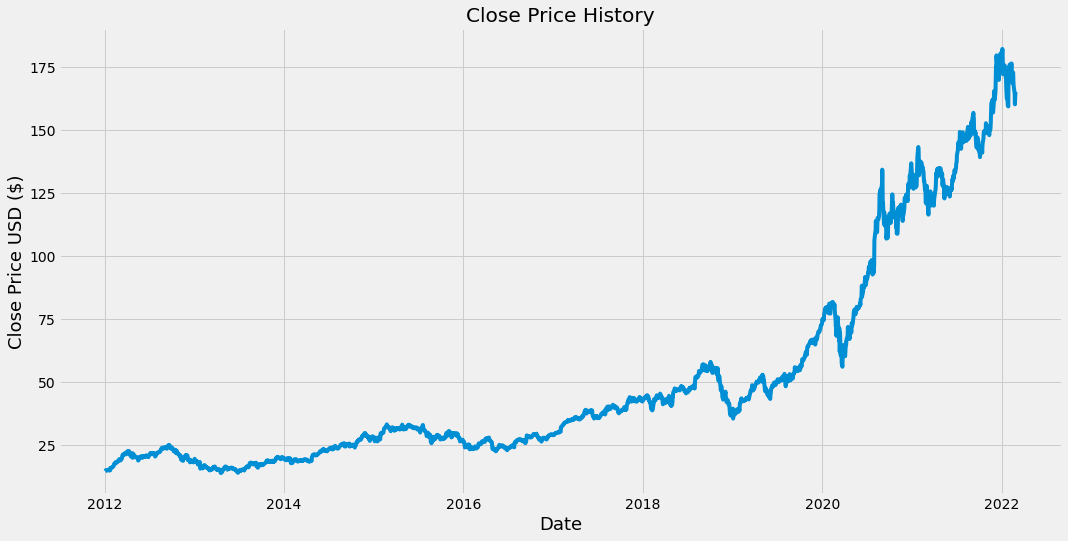

In [5]:
#visualize data for the closing
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [6]:
#Create a new dataframe with only the Close Column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)

training_data_len

2045

In [7]:
#Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00439887],
       [0.00486851],
       [0.00584391],
       ...,
       [0.88534034],
       [0.89789519],
       [0.89950167]])

In [8]:
#Create the training data set
#Create the scaled training data set

train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

#Convert x_train and y_train to numpy array
        
x_train,y_train = np.array(x_train),np.array(y_train)

In [9]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1985, 60, 1)

In [10]:
#Build the LSTM Model
model = Sequential()

model.add(LSTM(50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.add(Dense(1))

2022-03-21 12:50:19.345741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-21 12:50:19.345768: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-21 12:50:19.345792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (soroush): /proc/driver/nvidia/version does not exist
2022-03-21 12:50:19.346017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#Compile the model

model.compile(optimizer='adam',loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1985/1985 [==============================] - 62s 30ms/step - loss: 1.6314e-04


In [14]:
#Create testing data set
test_data = scaled_data[training_data_len-60:,:]
test_data
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

#Convert x_test to numpy array
        
x_test = np.array(x_test)
x_test.shape

(511, 60)

In [15]:
#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(511, 60, 1)

In [16]:
#Get the model prediction price value

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


In [17]:
#Get the Root Main Squared Error(RMSE)
rmse= np.sqrt(np.mean(predictions- y_test)**2)
rmse


0.13517208808555528

/tmp/ipykernel_4940/1661452209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions']=predictions


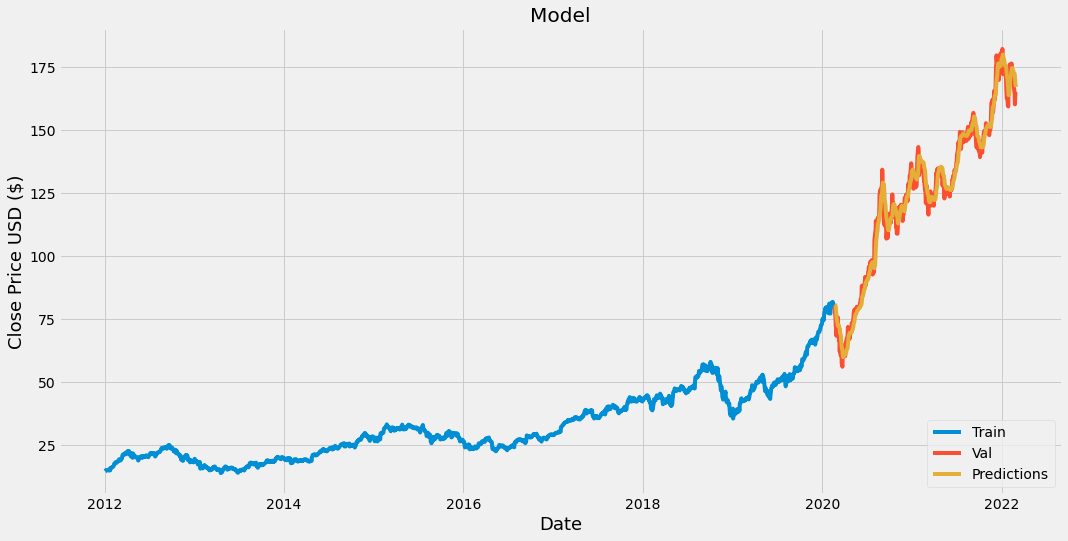

In [19]:
#plot  the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']=predictions
#Visualize the data
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'],loc = 'lower right')
plt.show()


In [20]:
# Show the valid and predicted data
valid

,Close,Predictions
Date,,
2020-02-20,80.074997,80.688194
2020-02-21,78.262497,80.639404
2020-02-24,74.544998,80.352371
2020-02-25,72.019997,79.563942
2020-02-26,73.162498,78.315155
...,...,...
2022-02-22,164.320007,172.152420
2022-02-23,160.070007,171.072006
2022-02-24,162.740005,169.439011


In [29]:
# get the stock quote
apple_quote = web.DataReader('AAPL',data_source = 'yahoo',start = '2012-01-01', end = '2022-03-17')

#Create a new dataframe with only the Close Column
new_df = apple_quote.filter(['Close'])
#Convert the dataframe to a numpy array
last_60_days = new_df[-60:].values
#Get the number of rows to train the model on
last_60_days_scaled = scaler.transform(last_60_days)
#create an empty list
X_test = []

X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test= np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaled
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[158.27167]]


In [28]:
apple_quote2 = web.DataReader('AAPL',data_source = 'yahoo',start = '2022-03-18', end = '2022-03-18')
print(apple_quote2['Close'])

Date
2022-03-18    163.979996
2022-03-18    163.979996
Name: Close, dtype: float64
